In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torch
from torch.autograd import Variable
from PIL import Image
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm
import zipfile

In [7]:
zip = zipfile.ZipFile('fashion-mnist.zip')
zip.extractall()

In [2]:
train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashio-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

In [3]:
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
    Y_train.append( int(train_file.split('\\')[1]) )
    X_train.append(np.array(Image.open(train_file)))
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
    Y_valid.append( int(valid_file.split('\\')[1]) )
    X_valid.append( np.array(Image.open(valid_file)) )
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
    Y_test.append( int(test_file.split('\\')[1]) )
    X_test.append( np.array(Image.open(test_file)) )

In [4]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

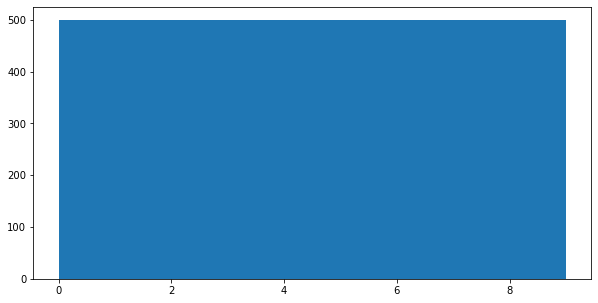

In [5]:
fig,ax = plt.subplots(figsize=(10,5))
ax.hist(Y_test.numpy())
plt.show()

### Las clases están balanceadas


In [56]:
batch_size = 32
train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=3),
  # ( (28-5+2*2)/1 ) + 1 = 16   -> 16*16*32

  torch.nn.Sigmoid(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 16/2 = 8                 -> 8*8*32

  torch.nn.Dropout(p=0.15),

  torch.nn.Conv2d(32, 40, kernel_size=3, stride=1, padding=3),
  # ( (8-5+2*2)/1 ) + 1 = 12   -> 12*12*40

  torch.nn.Sigmoid(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 12/2 = 6                 -> 6*6*40

  torch.nn.Dropout(p=0.1), 

  torch.nn.Flatten(),
  torch.nn.Linear(6*6*40, 10)
)
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.15, inplace=False)
  (4): Conv2d(32, 40, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
  (5): Sigmoid()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.1, inplace=False)
  (8): Flatten()
  (9): Linear(in_features=1440, out_features=10, bias=True)
)

In [57]:

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [58]:
from sklearn.metrics import f1_score, accuracy_score

n_epoch = 10

it = 0
f1_list = []
acc_list = []
loss_list = []
for epoch in range(n_epoch):
    for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
        model.train()
        Xtr = X_train_batch.unsqueeze(1)
        Y_pred = model(Xtr)

        loss = criterion(Y_pred,Y_train_batch)

        Y_pred = torch.argmax(Y_pred, 1)
        f1 = f1_score(Y_train_batch, Y_pred, average='macro')    

        acc = accuracy_score(Y_train_batch,Y_pred)
        loss_list.append(loss.item())
        f1_list.append(f1)
        acc_list.append(acc)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


Text(0.5, 0, 'iteration')

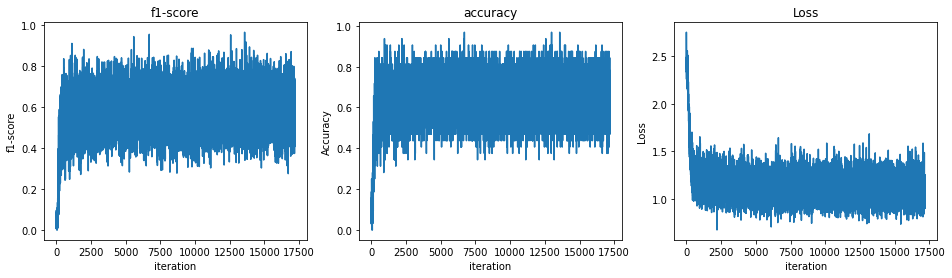

In [64]:
fig, ax = plt.subplots(figsize = (16,4), nrows = 1, ncols = 3)
ax[0].plot(f1_list)
ax[0].set_title('f1-score')
ax[0].set_ylabel('f1-score')
ax[0].set_xlabel('iteration')
ax[1].plot(acc_list)
ax[1].set_title('accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('iteration')
ax[2].plot(loss_list)
ax[2].set_title('Loss')
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('iteration')


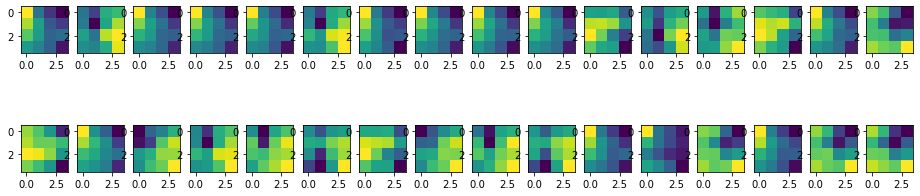

In [62]:
kernels = list(model.children())[0].weight.detach()

fig = plt.figure(figsize=(16,4))
k = 0
for i in range(kernels.size(0)):
    plt.subplot(2,16,k+1)
    plt.imshow(kernels[i].squeeze())
    k += 1
plt.show()

In [67]:
model.eval()
Xtr = X_test.unsqueeze(1)
Y_pred = model(Xtr)

loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')    

acc = accuracy_score(Y_test,Y_pred)
print('Los resultados obtenidos para el modelo son: f1 = {}, accuracy = {}, loss = {}'.format(f1,acc, loss.item()))

Los resultados obtenidos para el modelo son: f1 = 0.5415431705924407, accuracy = 0.603, loss = 1.123900055885315


## Conclusiones 

El modelo se compone de dos capas convolucionales, la primera tiene 1 entrada y 32 salidas, con un kernel de 4x4, un padding de 3 y stride de 2. Luego sigue una capa de Max pool con un kernel de 2x2, es decir, reducimos las características en la mitad. Luego, otra capa convolucional de 40 salidas, seguida de otra capa de Max pool con otro kernel de 2x2. Entremedio existen capas de dropout, la primera con probabilidad 0.15 y la segunda con 0.1. 

Las funciones de activación son sigmoidales, por lo cual para valores negativos de la convolución también se tienen valores distintos de cero. 

Finalmente, al evaluar el modelo nos damos cuenta de una gran variación en la perdida, en el f1 y en el accuracy. Esto se puede explicar desde una mala escogencia de parámetros para el batch-size. Esto quiere decir que se está entrenando con un batch size muy grande y por esto el modelo tiene mucho ruido.